In [1]:
# ==========================================
# 0. Imports & Device
# ==========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 재현성(선택)
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# ==========================================
# 1. Load Data (train + validation)
# ==========================================
train_seq = pd.read_csv('train_sequences.csv')
val_seq   = pd.read_csv('validation_sequences.csv')

# low_memory=False로 mixed dtype 경고 완화
train_labels = pd.read_csv('train_labels.csv', low_memory=False)
val_labels   = pd.read_csv('validation_labels.csv', low_memory=False)

print(f"Train seq shape: {train_seq.shape}")
print(f"Val   seq shape: {val_seq.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Val   labels shape: {val_labels.shape}")


Train seq shape: (5716, 8)
Val   seq shape: (28, 8)
Train labels shape: (7794971, 8)
Val   labels shape: (9762, 126)


In [3]:
# ==========================================
# 2. Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize(seq: str):
    return [mapping.get(b, 0) for b in str(seq)]

for df in (train_seq, val_seq):
    df['target_id'] = df['target_id'].astype(str).str.strip()
    df['tokenized'] = df['sequence'].apply(tokenize)

print("Tokenized train/val sequences.")


Tokenized train/val sequences.


In [4]:
# ==========================================
# 3. Label preprocessing (train + validation)
#    - train_labels: (x_1,y_1,z_1) 단일 구조
#    - val_labels: (x_1..z_40) 다중 슬롯 + 결측이 -1e18 같은 센티넬로 들어있음
#      => isfinite만으로는 결측을 못 걸러서 abs<threshold 조건을 추가
# ==========================================
XYZ = ['x_1','y_1','z_1']
ABS_THRESH = 1e17   # -1e18 같은 센티넬 결측 제거용
MIN_VALID_POINTS = 30  # 너무 결측이 많은 target 제거(안정성)

def _clean_base(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _clean_base(train_labels)

    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)

    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < ABS_THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)

    # 결측은 0으로 채우고 mask로 제외
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    # target 단위 유효 포인트 수 기준 필터
    valid_counts = df.groupby('target_id')['coord_ok'].sum()
    good_ids = valid_counts[valid_counts >= MIN_VALID_POINTS].index
    df = df[df['target_id'].isin(good_ids)].copy()

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df = (df.groupby('target_id')['coord_ok']
               .apply(lambda x: x.to_numpy(np.float32).tolist())
               .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _clean_base(val_labels)

    # 각 row(residue)마다 k=1..K 중 '처음으로 유효한' 좌표를 선택해 (x_1,y_1,z_1)에 저장
    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)

        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < ABS_THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'], df['y_1'], df['z_1'] = chosen[:,0], chosen[:,1], chosen[:,2]
    df['coord_ok'] = ok_mask

    # target 단위 유효 포인트 수 기준 필터
    valid_counts = df.groupby('target_id')['coord_ok'].sum()
    good_ids = valid_counts[valid_counts >= MIN_VALID_POINTS].index
    df = df[df['target_id'].isin(good_ids)].copy()

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df = (df.groupby('target_id')['coord_ok']
               .apply(lambda x: x.to_numpy(np.float32).tolist())
               .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

# key 정리
train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

# seq/coords 합치기
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_df = all_seq.merge(all_coords, on='target_id', how='inner')
print("all_df shape:", all_df.shape)

# max_len 창에서 유효 포인트가 너무 적으면 제거 (Kabsch 안정화)
MAX_LEN = 200
all_df['valid_in_window'] = all_df['coord_mask'].apply(
    lambda m: float(np.sum(np.asarray(m, dtype=np.float32)[:MAX_LEN]))
)
before = len(all_df)
all_df = all_df[all_df['valid_in_window'] >= 30].copy()
print(f"Filtered all_df by valid_in_window>=30: {before} -> {len(all_df)}")

# sanity: NaN/Inf check
def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())
print("NaN/Inf coords after cleaning:", all_df['coordinates'].apply(has_nan_inf).sum())


all_df shape: (4750, 11)
Filtered all_df by valid_in_window>=30: 4750 -> 4747
NaN/Inf coords after cleaning: 0


In [5]:
# ==========================================
# 4. Kabsch RMSD Loss (mask supported, and correct SVD handling)
# ==========================================
def kabsch_rotation(P, Q, mask=None):
    """
    P, Q: (B, N, 3)
    mask: (B, N)  1(valid), 0(invalid/pad)
    """
    if mask is None:
        mask = torch.ones(P.shape[0], P.shape[1], device=P.device, dtype=P.dtype)

    mask_exp = mask.unsqueeze(-1)  # (B,N,1)
    mask_sum = mask_exp.sum(dim=1, keepdim=True).clamp_min(1e-8)

    P_mean = (P * mask_exp).sum(dim=1, keepdim=True) / mask_sum
    Q_mean = (Q * mask_exp).sum(dim=1, keepdim=True) / mask_sum

    P_c = (P - P_mean) * mask_exp
    Q_c = (Q - Q_mean) * mask_exp

    H = torch.matmul(P_c.transpose(1, 2), Q_c)  # (B,3,3)

    # torch.linalg.svd returns U,S,Vh
    U, S, Vh = torch.linalg.svd(H, full_matrices=False)
    V = Vh.transpose(1, 2)

    det = torch.det(torch.matmul(V, U.transpose(1, 2)))
    sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

    E = torch.eye(3, device=P.device, dtype=P.dtype).unsqueeze(0).repeat(P.shape[0], 1, 1)
    E[:, 2, 2] = sign

    R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2))  # (B,3,3)
    P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean

    return P_aligned * mask_exp


class KabschRMSDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, target, mask):
        """
        preds : (B, K, N, 3)
        target: (B, N, 3)
        mask  : (B, N) 1(valid), 0(invalid/pad)
        """
        B, K, N, _ = preds.shape
        losses = []
        for k in range(K):
            pred_k = preds[:, k, :, :]
            pred_aligned = kabsch_rotation(pred_k, target, mask)

            diff_sq = (pred_aligned - target) ** 2
            sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
            n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)           # (B,)
            mse = sum_sq / n_valid
            rmsd = torch.sqrt(mse + 1e-8)
            losses.append(rmsd)

        losses = torch.stack(losses, dim=1)  # (B,K)
        min_loss, _ = torch.min(losses, dim=1)
        return torch.mean(min_loss)

In [6]:
# ==========================================
# 5. Dataset (uses coord_mask to ignore missing labels)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, sequences, coordinates, coord_masks, max_len=200):
        self.sequences = sequences
        self.coordinates = coordinates
        self.coord_masks = coord_masks
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        coords = np.asarray(self.coordinates[idx], dtype=np.float32)
        c_mask = np.asarray(self.coord_masks[idx], dtype=np.float32)

        # 안전하게 길이 맞추기
        L = min(len(seq), coords.shape[0], c_mask.shape[0], self.max_len)

        # seq padding
        seq_padded = np.zeros(self.max_len, dtype=np.int64)
        seq_padded[:L] = np.asarray(seq[:L], dtype=np.int64)

        # coords padding
        coords_padded = np.zeros((self.max_len, 3), dtype=np.float32)
        coords_padded[:L] = coords[:L]

        # 최종 mask: 라벨 유효(coord_ok)만 1 (패딩/결측은 0)
        mask = np.zeros(self.max_len, dtype=np.float32)
        mask[:L] = c_mask[:L]

        return (
            torch.tensor(seq_padded, dtype=torch.long),
            torch.tensor(coords_padded, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.float32),
        )

In [7]:
# ==========================================
# 6. Train/Holdout split & DataLoaders
#    - val을 학습 데이터로 포함했으므로, 별도 holdout을 만든다
# ==========================================
train_idx, val_idx = train_test_split(range(len(all_df)), test_size=0.1, random_state=42)

train_df = all_df.iloc[train_idx].reset_index(drop=True)
hold_df  = all_df.iloc[val_idx].reset_index(drop=True)

print("train_df:", train_df.shape, "hold_df:", hold_df.shape)

train_dataset = RNADataset(
    train_df['tokenized'].values,
    train_df['coordinates'].values,
    train_df['coord_mask'].values,
    max_len=200
)
val_dataset = RNADataset(
    hold_df['tokenized'].values,
    hold_df['coordinates'].values,
    hold_df['coord_mask'].values,
    max_len=200
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


train_df: (4272, 12) hold_df: (475, 12)


In [8]:
# ==========================================
# 7. Model (Transformer + padding mask for attention)
# ==========================================
class RNATransformer(nn.Module):
    def __init__(self, n_tokens=5, d_model=128, nhead=8, num_layers=4, dropout=0.1, num_preds=5):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.num_preds = num_preds
        self.fc_coords = nn.Linear(d_model, 3 * num_preds)

    def forward(self, tokens):
        # tokens: (B,T)
        B, T = tokens.shape
        padding_mask = (tokens == 0)  # True at PAD positions

        x = self.embedding(tokens)
        x = x + self.pos_encoder[:, :T, :]
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)

        out = self.fc_coords(x)  # (B,T,3*K)
        out = out.view(B, T, self.num_preds, 3).permute(0, 2, 1, 3)  # (B,K,T,3)
        return out

model = RNATransformer(num_preds=5).to(device)
print("Model Initialized (Best-of-5 Output Strategy).")


Model Initialized (Best-of-5 Output Strategy).


In [9]:
# ==========================================
# 8. Train v3: 2-Stage Loss (Masked L1 warmup -> Kabsch), LR Scheduler, Early Stopping
# ==========================================
import math

def masked_l1_loss(preds, target, mask):
    """
    preds : (B, K, T, 3)
    target: (B, T, 3)
    mask  : (B, T) 1(valid), 0(invalid/pad)

    Best-of-K: pick the minimum loss among K predictions.
    """
    B, K, T, C = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)

    losses = []
    for k in range(K):
        pk = preds[:, k]  # (B,T,3)
        diff = (pk - target).abs() * m
        denom = m.sum(dim=(1,2)).clamp_min(1.0)   # (B,)
        l1 = diff.sum(dim=(1,2)) / denom          # (B,)
        losses.append(l1)

    losses = torch.stack(losses, dim=1)  # (B,K)
    min_loss, _ = torch.min(losses, dim=1)
    return min_loss.mean()


# ---- Config ----
epochs = 50
warmup_epochs = 5           # first 5 epochs use masked L1, then switch to Kabsch
patience = 7
min_delta = 1e-4
best_path = "best_v3.pt"

# Optimizer (stable default for this setup)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)

# LR scheduler: warmup + cosine decay (step-based)
total_steps = epochs * len(train_loader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Criterion for stage 2
criterion = KabschRMSDLoss()

# Early stopping state
best_val = float("inf")
stale = 0
global_step = 0

print(f"Starting v3 training: epochs={epochs}, warmup_epochs={warmup_epochs}, patience={patience}")

for epoch in range(epochs):
    use_kabsch = (epoch >= warmup_epochs)
    stage = "KABSCH" if use_kabsch else "MASKED_L1"

    # =========================
    # Train
    # =========================
    model.train()
    train_loss_sum = 0.0
    train_steps = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [{stage}]")
    for seq, target, mask in pbar:
        seq = seq.to(device)
        target = target.to(device)
        mask = mask.to(device)

        # Filter samples with too few valid points inside the training window
        valid_counts = mask.sum(dim=1)  # (B,)
        keep = valid_counts >= 20       # 안정 마진 (필요하면 10/30으로 조절)

        if keep.sum() < 2:
            continue

        seq = seq[keep]
        target = target[keep]
        mask = mask[keep]

        optimizer.zero_grad(set_to_none=True)

        preds = model(seq)  # (B,K,T,3)

        if use_kabsch:
            loss = criterion(preds, target, mask)
        else:
            loss = masked_l1_loss(preds, target, mask)

        if not torch.isfinite(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        scheduler.step()
        global_step += 1

        train_loss_sum += loss.item()
        train_steps += 1

        lr_now = optimizer.param_groups[0]["lr"]
        pbar.set_postfix({"loss": float(loss.item()), "lr": lr_now, "kept": int(keep.sum())})

    avg_train = train_loss_sum / max(1, train_steps)

    # =========================
    # Validation
    # =========================
    model.eval()
    val_loss_sum = 0.0
    val_steps = 0

    with torch.no_grad():
        for seq, target, mask in val_loader:
            seq = seq.to(device)
            target = target.to(device)
            mask = mask.to(device)

            valid_counts = mask.sum(dim=1)
            keep = valid_counts >= 20
            if keep.sum() < 2:
                continue

            seq = seq[keep]
            target = target[keep]
            mask = mask[keep]

            preds = model(seq)

            if use_kabsch:
                loss = criterion(preds, target, mask)
            else:
                loss = masked_l1_loss(preds, target, mask)

            if not torch.isfinite(loss):
                continue

            val_loss_sum += loss.item()
            val_steps += 1

    avg_val = val_loss_sum / max(1, val_steps)
    print(f"[Epoch {epoch+1:02d}] stage={stage:9s}  train={avg_train:.6f}  val={avg_val:.6f}  steps(train/val)={train_steps}/{val_steps}")

    # =========================
    # Early stopping (only enforce after warmup)
    # =========================
    if avg_val < best_val - min_delta:
        best_val = avg_val
        stale = 0
        torch.save(model.state_dict(), best_path)
        print(f"✅ New best saved: val={best_val:.6f}")
    else:
        stale += 1
        print(f"⏸ No improvement: {stale}/{patience}")
        if epoch >= warmup_epochs and stale >= patience:
            print("🛑 Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load(best_path, map_location=device))
print(f"✅ Best model loaded from {best_path} (best val={best_val:.6f})")


Starting v3 training: epochs=50, warmup_epochs=5, patience=7


Epoch 1/50 [MASKED_L1]: 100%|██████████| 133/133 [00:06<00:00, 19.58it/s, loss=466, lr=1.21e-5, kept=32]
c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


[Epoch 01] stage=MASKED_L1  train=349.250050  val=351.243083  steps(train/val)=133/15
✅ New best saved: val=351.243083


Epoch 2/50 [MASKED_L1]: 100%|██████████| 133/133 [00:06<00:00, 20.13it/s, loss=377, lr=2.41e-5, kept=32]


[Epoch 02] stage=MASKED_L1  train=344.424957  val=347.439056  steps(train/val)=133/15
✅ New best saved: val=347.439056


Epoch 3/50 [MASKED_L1]: 100%|██████████| 133/133 [00:06<00:00, 19.16it/s, loss=352, lr=3e-5, kept=32]  


[Epoch 03] stage=MASKED_L1  train=342.297656  val=346.152260  steps(train/val)=133/15
✅ New best saved: val=346.152260


Epoch 4/50 [MASKED_L1]: 100%|██████████| 133/133 [00:07<00:00, 18.76it/s, loss=381, lr=2.99e-5, kept=32]


[Epoch 04] stage=MASKED_L1  train=341.140951  val=344.952854  steps(train/val)=133/15
✅ New best saved: val=344.952854


Epoch 5/50 [MASKED_L1]: 100%|██████████| 133/133 [00:07<00:00, 17.03it/s, loss=391, lr=2.98e-5, kept=32]


[Epoch 05] stage=MASKED_L1  train=340.310098  val=343.744519  steps(train/val)=133/15
✅ New best saved: val=343.744519


Epoch 6/50 [KABSCH]: 100%|██████████| 133/133 [01:03<00:00,  2.08it/s, loss=20.8, lr=2.96e-5, kept=32]


[Epoch 06] stage=KABSCH     train=21.212576  val=21.397928  steps(train/val)=133/15
✅ New best saved: val=21.397928


Epoch 7/50 [KABSCH]: 100%|██████████| 133/133 [00:20<00:00,  6.38it/s, loss=19.5, lr=2.93e-5, kept=32]


[Epoch 07] stage=KABSCH     train=21.154233  val=21.265159  steps(train/val)=133/15
✅ New best saved: val=21.265159


Epoch 8/50 [KABSCH]: 100%|██████████| 133/133 [00:31<00:00,  4.26it/s, loss=21.5, lr=2.9e-5, kept=32] 


[Epoch 08] stage=KABSCH     train=21.067364  val=21.254075  steps(train/val)=133/15
✅ New best saved: val=21.254075


Epoch 9/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.01it/s, loss=20.6, lr=2.86e-5, kept=32]


[Epoch 09] stage=KABSCH     train=21.027861  val=21.119254  steps(train/val)=133/15
✅ New best saved: val=21.119254


Epoch 10/50 [KABSCH]: 100%|██████████| 133/133 [00:19<00:00,  6.75it/s, loss=22.3, lr=2.82e-5, kept=32]


[Epoch 10] stage=KABSCH     train=20.856924  val=20.994527  steps(train/val)=133/15
✅ New best saved: val=20.994527


Epoch 11/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.00it/s, loss=21.4, lr=2.77e-5, kept=32]


[Epoch 11] stage=KABSCH     train=20.811250  val=20.911615  steps(train/val)=133/15
✅ New best saved: val=20.911615


Epoch 12/50 [KABSCH]: 100%|██████████| 133/133 [00:19<00:00,  6.74it/s, loss=21.5, lr=2.71e-5, kept=32]


[Epoch 12] stage=KABSCH     train=20.528128  val=20.269711  steps(train/val)=133/15
✅ New best saved: val=20.269711


Epoch 13/50 [KABSCH]: 100%|██████████| 133/133 [00:19<00:00,  6.74it/s, loss=18.1, lr=2.65e-5, kept=32]


[Epoch 13] stage=KABSCH     train=19.952989  val=19.549380  steps(train/val)=133/15
✅ New best saved: val=19.549380


Epoch 14/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.09it/s, loss=23.3, lr=2.59e-5, kept=32]


[Epoch 14] stage=KABSCH     train=19.432187  val=19.091323  steps(train/val)=133/15
✅ New best saved: val=19.091323


Epoch 15/50 [KABSCH]: 100%|██████████| 133/133 [00:31<00:00,  4.26it/s, loss=16.9, lr=2.52e-5, kept=32]


[Epoch 15] stage=KABSCH     train=19.038075  val=18.906910  steps(train/val)=133/15
✅ New best saved: val=18.906910


Epoch 16/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.41it/s, loss=19.8, lr=2.44e-5, kept=32]


[Epoch 16] stage=KABSCH     train=18.751919  val=18.687670  steps(train/val)=133/15
✅ New best saved: val=18.687670


Epoch 17/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.51it/s, loss=19.8, lr=2.36e-5, kept=32]


[Epoch 17] stage=KABSCH     train=18.526113  val=18.526785  steps(train/val)=133/15
✅ New best saved: val=18.526785


Epoch 18/50 [KABSCH]: 100%|██████████| 133/133 [00:36<00:00,  3.62it/s, loss=18.3, lr=2.28e-5, kept=32]


[Epoch 18] stage=KABSCH     train=18.346008  val=18.376488  steps(train/val)=133/15
✅ New best saved: val=18.376488


Epoch 19/50 [KABSCH]: 100%|██████████| 133/133 [01:11<00:00,  1.85it/s, loss=17, lr=2.19e-5, kept=32]  


[Epoch 19] stage=KABSCH     train=18.139762  val=18.068877  steps(train/val)=133/15
✅ New best saved: val=18.068877


Epoch 20/50 [KABSCH]: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s, loss=19.4, lr=2.1e-5, kept=32] 


[Epoch 20] stage=KABSCH     train=17.951431  val=17.936247  steps(train/val)=133/15
✅ New best saved: val=17.936247


Epoch 21/50 [KABSCH]: 100%|██████████| 133/133 [00:13<00:00,  9.97it/s, loss=18.3, lr=2.01e-5, kept=32]


[Epoch 21] stage=KABSCH     train=17.815642  val=17.836983  steps(train/val)=133/15
✅ New best saved: val=17.836983


Epoch 22/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.77it/s, loss=17.6, lr=1.92e-5, kept=32]


[Epoch 22] stage=KABSCH     train=17.739922  val=17.778809  steps(train/val)=133/15
✅ New best saved: val=17.778809


Epoch 23/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.67it/s, loss=16.8, lr=1.82e-5, kept=32]


[Epoch 23] stage=KABSCH     train=17.669385  val=17.712598  steps(train/val)=133/15
✅ New best saved: val=17.712598


Epoch 24/50 [KABSCH]: 100%|██████████| 133/133 [01:04<00:00,  2.08it/s, loss=18.4, lr=1.72e-5, kept=32]


[Epoch 24] stage=KABSCH     train=17.598520  val=17.648957  steps(train/val)=133/15
✅ New best saved: val=17.648957


Epoch 25/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.02it/s, loss=18.6, lr=1.62e-5, kept=32]


[Epoch 25] stage=KABSCH     train=17.561391  val=17.605543  steps(train/val)=133/15
✅ New best saved: val=17.605543


Epoch 26/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.88it/s, loss=18.6, lr=1.52e-5, kept=32]


[Epoch 26] stage=KABSCH     train=17.498541  val=17.548466  steps(train/val)=133/15
✅ New best saved: val=17.548466


Epoch 27/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.86it/s, loss=16.5, lr=1.43e-5, kept=32]


[Epoch 27] stage=KABSCH     train=17.442627  val=17.527355  steps(train/val)=133/15
✅ New best saved: val=17.527355


Epoch 28/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.61it/s, loss=16.5, lr=1.33e-5, kept=32]


[Epoch 28] stage=KABSCH     train=17.404433  val=17.470025  steps(train/val)=133/15
✅ New best saved: val=17.470025


Epoch 29/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.61it/s, loss=15.6, lr=1.23e-5, kept=32]


[Epoch 29] stage=KABSCH     train=17.359871  val=17.429347  steps(train/val)=133/15
✅ New best saved: val=17.429347


Epoch 30/50 [KABSCH]: 100%|██████████| 133/133 [00:25<00:00,  5.13it/s, loss=16.1, lr=1.13e-5, kept=32]


[Epoch 30] stage=KABSCH     train=17.333045  val=17.394454  steps(train/val)=133/15
✅ New best saved: val=17.394454


Epoch 31/50 [KABSCH]: 100%|██████████| 133/133 [00:34<00:00,  3.82it/s, loss=15.4, lr=1.04e-5, kept=32]


[Epoch 31] stage=KABSCH     train=17.293026  val=17.364722  steps(train/val)=133/15
✅ New best saved: val=17.364722


Epoch 32/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.13it/s, loss=16.5, lr=9.43e-6, kept=32]


[Epoch 32] stage=KABSCH     train=17.258171  val=17.342178  steps(train/val)=133/15
✅ New best saved: val=17.342178


Epoch 33/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.12it/s, loss=18.1, lr=8.52e-6, kept=32]


[Epoch 33] stage=KABSCH     train=17.241533  val=17.316063  steps(train/val)=133/15
✅ New best saved: val=17.316063


Epoch 34/50 [KABSCH]: 100%|██████████| 133/133 [00:19<00:00,  6.81it/s, loss=18.3, lr=7.64e-6, kept=32]


[Epoch 34] stage=KABSCH     train=17.203822  val=17.295064  steps(train/val)=133/15
✅ New best saved: val=17.295064


Epoch 35/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.11it/s, loss=16.6, lr=6.79e-6, kept=32]


[Epoch 35] stage=KABSCH     train=17.199588  val=17.283663  steps(train/val)=133/15
✅ New best saved: val=17.283663


Epoch 36/50 [KABSCH]: 100%|██████████| 133/133 [00:42<00:00,  3.15it/s, loss=17.1, lr=5.98e-6, kept=32]


[Epoch 36] stage=KABSCH     train=17.169636  val=17.280774  steps(train/val)=133/15
✅ New best saved: val=17.280774


Epoch 37/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.82it/s, loss=18.3, lr=5.21e-6, kept=32]


[Epoch 37] stage=KABSCH     train=17.140233  val=17.239630  steps(train/val)=133/15
✅ New best saved: val=17.239630


Epoch 38/50 [KABSCH]: 100%|██████████| 133/133 [00:42<00:00,  3.11it/s, loss=16.8, lr=4.48e-6, kept=32]


[Epoch 38] stage=KABSCH     train=17.130882  val=17.241445  steps(train/val)=133/15
⏸ No improvement: 1/7


Epoch 39/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.98it/s, loss=18.1, lr=3.8e-6, kept=32] 


[Epoch 39] stage=KABSCH     train=17.116122  val=17.216390  steps(train/val)=133/15
✅ New best saved: val=17.216390


Epoch 40/50 [KABSCH]: 100%|██████████| 133/133 [00:53<00:00,  2.50it/s, loss=17.3, lr=3.16e-6, kept=32]


[Epoch 40] stage=KABSCH     train=17.104814  val=17.207566  steps(train/val)=133/15
✅ New best saved: val=17.207566


Epoch 41/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.97it/s, loss=16.5, lr=2.58e-6, kept=32]


[Epoch 41] stage=KABSCH     train=17.104990  val=17.205746  steps(train/val)=133/15
✅ New best saved: val=17.205746


Epoch 42/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.91it/s, loss=18.7, lr=2.05e-6, kept=32]


[Epoch 42] stage=KABSCH     train=17.113807  val=17.192225  steps(train/val)=133/15
✅ New best saved: val=17.192225


Epoch 43/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.65it/s, loss=16.6, lr=1.58e-6, kept=32]


[Epoch 43] stage=KABSCH     train=17.073926  val=17.191188  steps(train/val)=133/15
✅ New best saved: val=17.191188


Epoch 44/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.63it/s, loss=16.1, lr=1.17e-6, kept=32]


[Epoch 44] stage=KABSCH     train=17.082233  val=17.184588  steps(train/val)=133/15
✅ New best saved: val=17.184588


Epoch 45/50 [KABSCH]: 100%|██████████| 133/133 [00:53<00:00,  2.48it/s, loss=17.9, lr=8.13e-7, kept=32]


[Epoch 45] stage=KABSCH     train=17.088627  val=17.185708  steps(train/val)=133/15
⏸ No improvement: 1/7


Epoch 46/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.16it/s, loss=16.7, lr=5.22e-7, kept=32]


[Epoch 46] stage=KABSCH     train=17.077396  val=17.179801  steps(train/val)=133/15
✅ New best saved: val=17.179801


Epoch 47/50 [KABSCH]: 100%|██████████| 133/133 [00:19<00:00,  6.77it/s, loss=17.3, lr=2.94e-7, kept=32]


[Epoch 47] stage=KABSCH     train=17.083591  val=17.179836  steps(train/val)=133/15
⏸ No improvement: 1/7


Epoch 48/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.04it/s, loss=13.5, lr=1.31e-7, kept=32]


[Epoch 48] stage=KABSCH     train=17.077142  val=17.177986  steps(train/val)=133/15
✅ New best saved: val=17.177986


Epoch 49/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 16.02it/s, loss=17.5, lr=3.28e-8, kept=32]


[Epoch 49] stage=KABSCH     train=17.074634  val=17.177842  steps(train/val)=133/15
✅ New best saved: val=17.177842


Epoch 50/50 [KABSCH]: 100%|██████████| 133/133 [00:08<00:00, 15.89it/s, loss=18.7, lr=0, kept=32]       


[Epoch 50] stage=KABSCH     train=17.077267  val=17.177756  steps(train/val)=133/15
⏸ No improvement: 1/7
✅ Best model loaded from best_v3.pt (best val=17.177842)


In [10]:
# ==========================================
# 10. Visualization (uses mask correctly)
# ==========================================
seq_batch, target_batch, mask_batch = next(iter(val_loader))
seq_batch = seq_batch.to(device)
target_batch = target_batch.to(device)
mask_batch = mask_batch.to(device)

with torch.no_grad():
    pred_batch = model(seq_batch)  # (B,5,T,3)

mask0 = mask_batch[0].detach().cpu().numpy().astype(bool)
t0 = target_batch[0].detach().cpu().numpy()[mask0]     # (L_valid,3)
p0 = pred_batch[0, 0].detach().cpu().numpy()[mask0]    # pred k=0

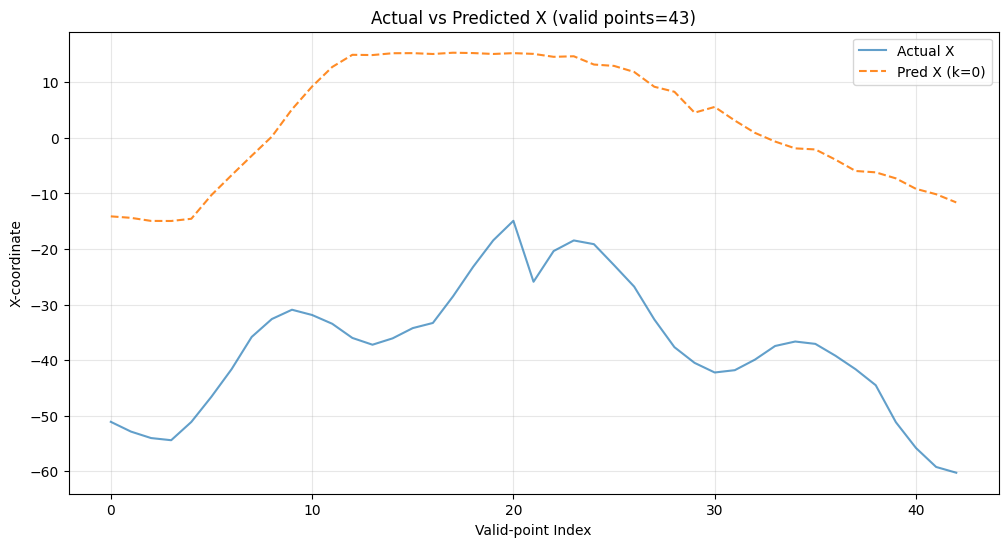

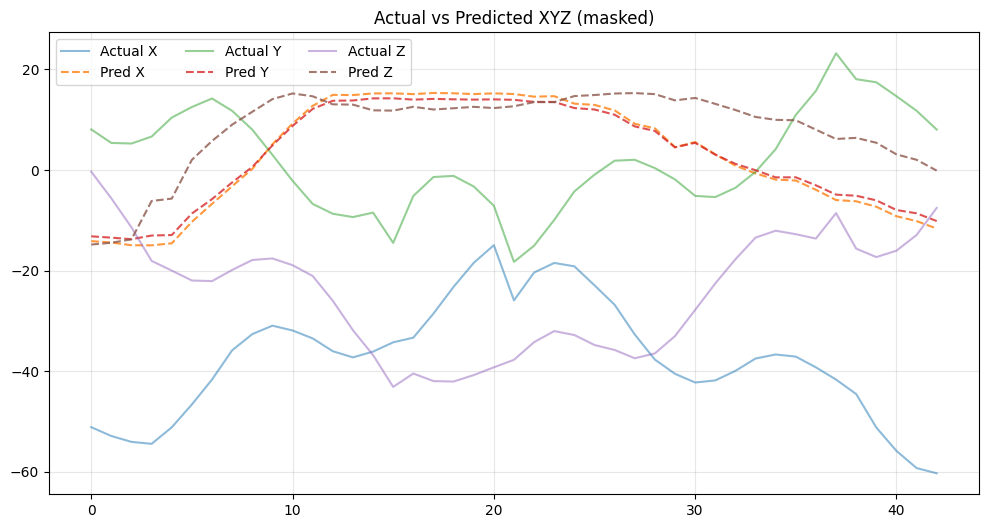

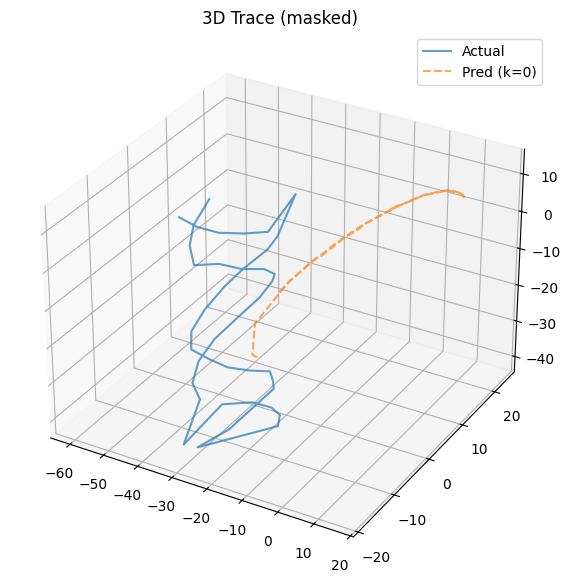

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(t0[:, 0], label="Actual X", alpha=0.7)
plt.plot(p0[:, 0], label="Pred X (k=0)", linestyle="--", alpha=0.9)
plt.title(f"Actual vs Predicted X (valid points={mask0.sum()})")
plt.xlabel("Valid-point Index")
plt.ylabel("X-coordinate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
for i, name in enumerate(["X", "Y", "Z"]):
    plt.plot(t0[:, i], label=f"Actual {name}", alpha=0.5)
    plt.plot(p0[:, i], label=f"Pred {name}", linestyle="--", alpha=0.8)
plt.title("Actual vs Predicted XYZ (masked)")
plt.legend(ncol=3)
plt.grid(alpha=0.3)
plt.show()

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(t0[:, 0], t0[:, 1], t0[:, 2], label="Actual", alpha=0.7)
ax.plot(p0[:, 0], p0[:, 1], p0[:, 2], label="Pred (k=0)", alpha=0.7, linestyle="--")
ax.set_title("3D Trace (masked)")
ax.legend()
plt.show()
